In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'darkgrid')

# Import Dataset

In [2]:
hydroswot = pd.read_csv('./HYDRoSWOT/SWOT_ADCP_Dataset.csv', converters={'site_no': str}, low_memory=False)
hydroswot.shape

(223022, 75)

This stipulation requires that each record include the `station identifier`,` latitude` and `longitude`, `the altitude of the gage at the station`, `the drainage area contributing to flow at the station`, and a `measured discharge`, `width`, `mean velocity`, and `mean depth`. We also stipulate that each record includes both `the maximum velocity` and `the maximum depth`.

In [3]:
candidate_columns=['site_no', 'dec_lat_va', 'dec_long_va', 'alt_va', 'drain_area_va', 'q_va', 'stream_wdth_va', 'mean_vel_va', 'mean_depth_va', 'max_vel_va', 'max_depth_va']

df = hydroswot.dropna(axis=0, how='any', subset=candidate_columns)
df.shape

(42553, 75)

To avoid the possible effects of localized obstructions in small channels that might cause highly variable hydraulic conditions, we restricted the analysis to streamflow measurements with top width greater than 15 $m$ and contributing drainage area greater than 13 $km^2$.

In [4]:
df = df[(df['drain_area_va'] > 5.01933) & (df['stream_wdth_va'] > 15)]
df.shape

(42178, 75)

we excluded negative flows from tidal effects and any records where (1) the maximum depth or velocity is less than the mean depth or velocity; (2) the ratio of maximum‐to‐mean velocity exceeds 10 (under the assumption that if the ratio is greater than this, the cross-section may contain extreme irregularities or multiple channels); and (3) the reported discharge is more than 5% greater or less than the discharge calculated by multiplying the reported width, mean depth, and mean velocity.

In [5]:
# negative flows from tidal effects
df = df[(df['q_va'] > 0.0)]
df.shape

(41990, 75)

In [6]:
# the maximum velocity is less than the mean velocity
df = df[(df['max_vel_va'] > df['mean_vel_va'])]
df.shape

(41933, 75)

In [7]:
# the maximum depth is less than the mean depth
df = df[(df['max_depth_va'] > df['mean_depth_va'])]
df.shape

(41755, 75)

In [8]:
# the ratio of maximum‐to‐mean velocity exceeds 10
df = df[(df['max_vel_va'] / df['mean_vel_va'] < 10)]
df.shape

(38377, 75)

In [9]:
# the reported discharge is more than 5% greater or less than the discharge calculated by multiplying the reported width, mean depth, and mean velocity
df = df[(df['q_va'] < 1.05 * df['mean_vel_va'] * df['stream_wdth_va'] * df['mean_depth_va'])]
df = df[(0.95 * df['mean_vel_va'] * df['stream_wdth_va'] * df['mean_depth_va'] < df['q_va'])]
df.shape

(23966, 75)

In [10]:
# Dropping rows with 0 value
df1 = df[(df[candidate_columns] != 0).all(axis=1)]
print(df1.shape)
df1['site_no'].value_counts().describe()

(23507, 75)


count    3954.000000
mean        5.945119
std         7.936076
min         1.000000
25%         2.000000
50%         3.000000
75%         8.000000
max       138.000000
Name: site_no, dtype: float64

In [23]:
candidate_columns = ['drain_area_va', 'q_va', 'stage_va', 'stream_wdth_va', 'xsec_area_va', 'mean_vel_va', 'mean_depth_va']

df2 = df1[candidate_columns]
df2.reset_index(inplace=True, drop=True)
df2.shape

In [36]:
# df3 = df2[(df2['q_va'] > df2['q_va'].quantile(0.05)) & (df2['q_va'] < df2['q_va'].quantile(0.95))]

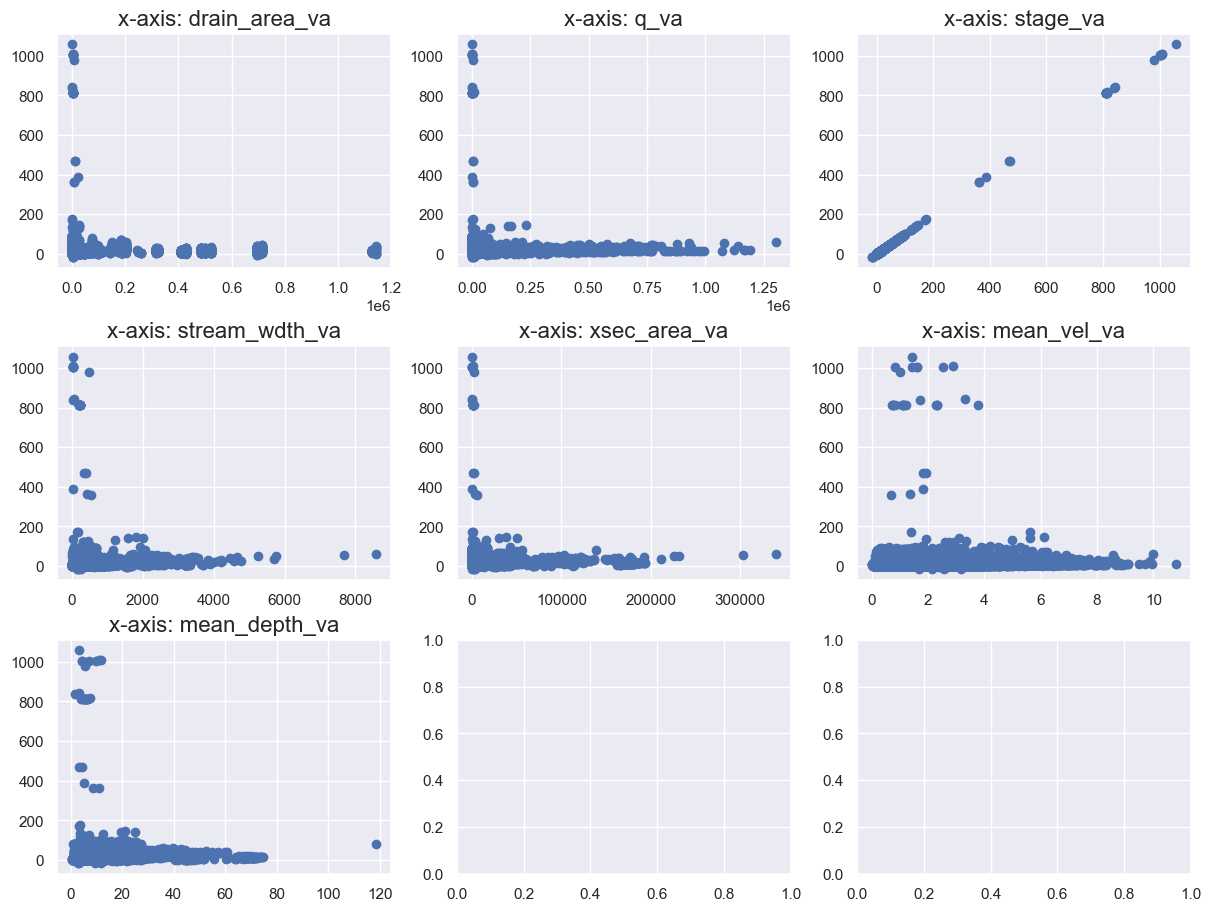

In [38]:
fig, axes = plt.subplots(nrows=3, ncols=3 , figsize=(12, 9), constrained_layout=True)

for index, (column_name, column_data) in enumerate(df2.iteritems()):
    # print(column_name, column_data); continue
    i, j = divmod(index, 3)

    axes[i, j].scatter(column_data, df2['stage_va'])
    axes[i, j].set_title(f'x-axis: {column_name}', fontsize=16)
    # axes[i, j].set_xlabel('')

# plt.savefig(f'{data_root}/results/boxplots.png')
plt.show()

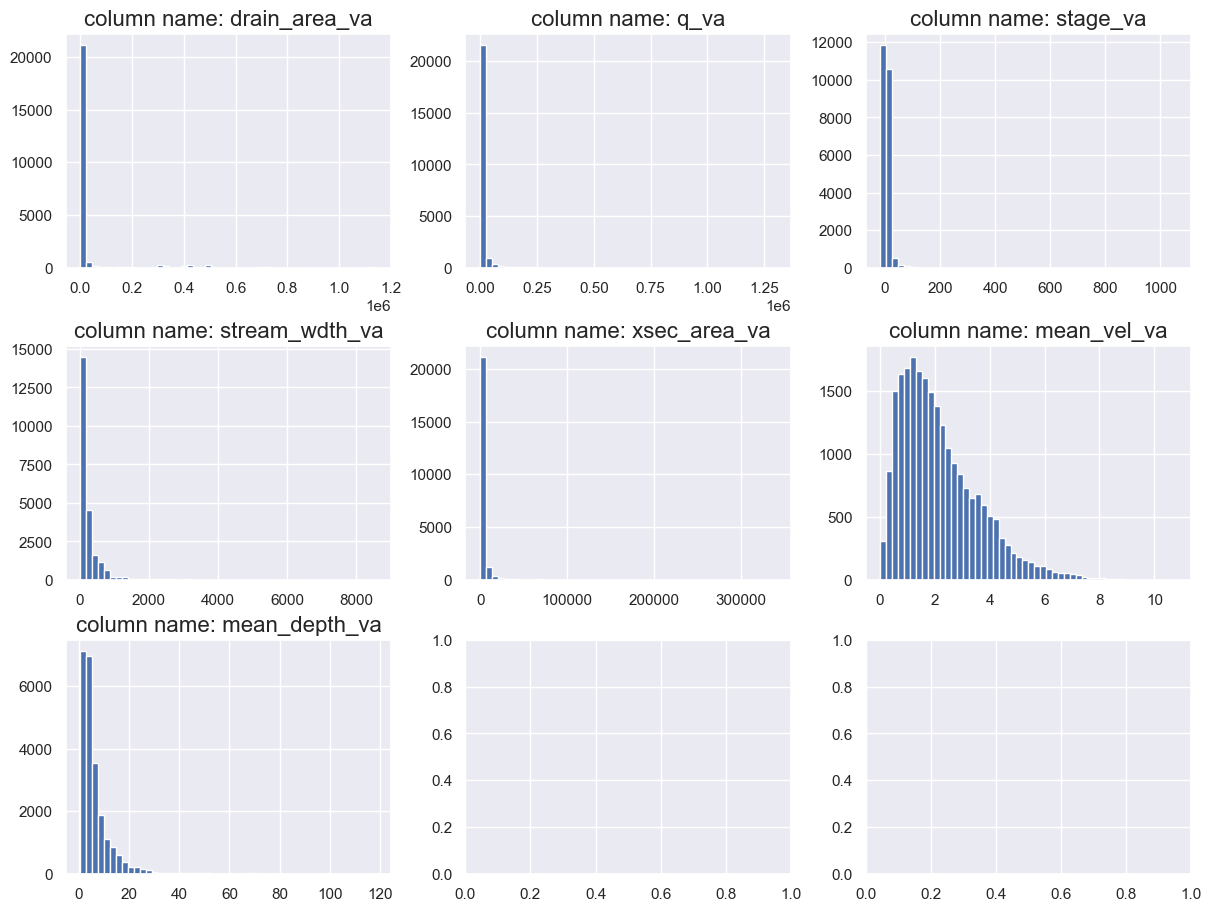

In [39]:
fig, axes = plt.subplots(nrows=3, ncols=3 , figsize=(12, 9), constrained_layout=True)

for index, (column_name, column_data) in enumerate(df2.iteritems()):
    i, j = divmod(index, 3)

    axes[i, j].hist(column_data, bins=50)
    axes[i, j].set_title(f'column name: {column_name}', fontsize=16)
    # axes[i, j].set_xlabel('')

# plt.savefig(f'{data_root}/results/boxplots.png')
plt.show()

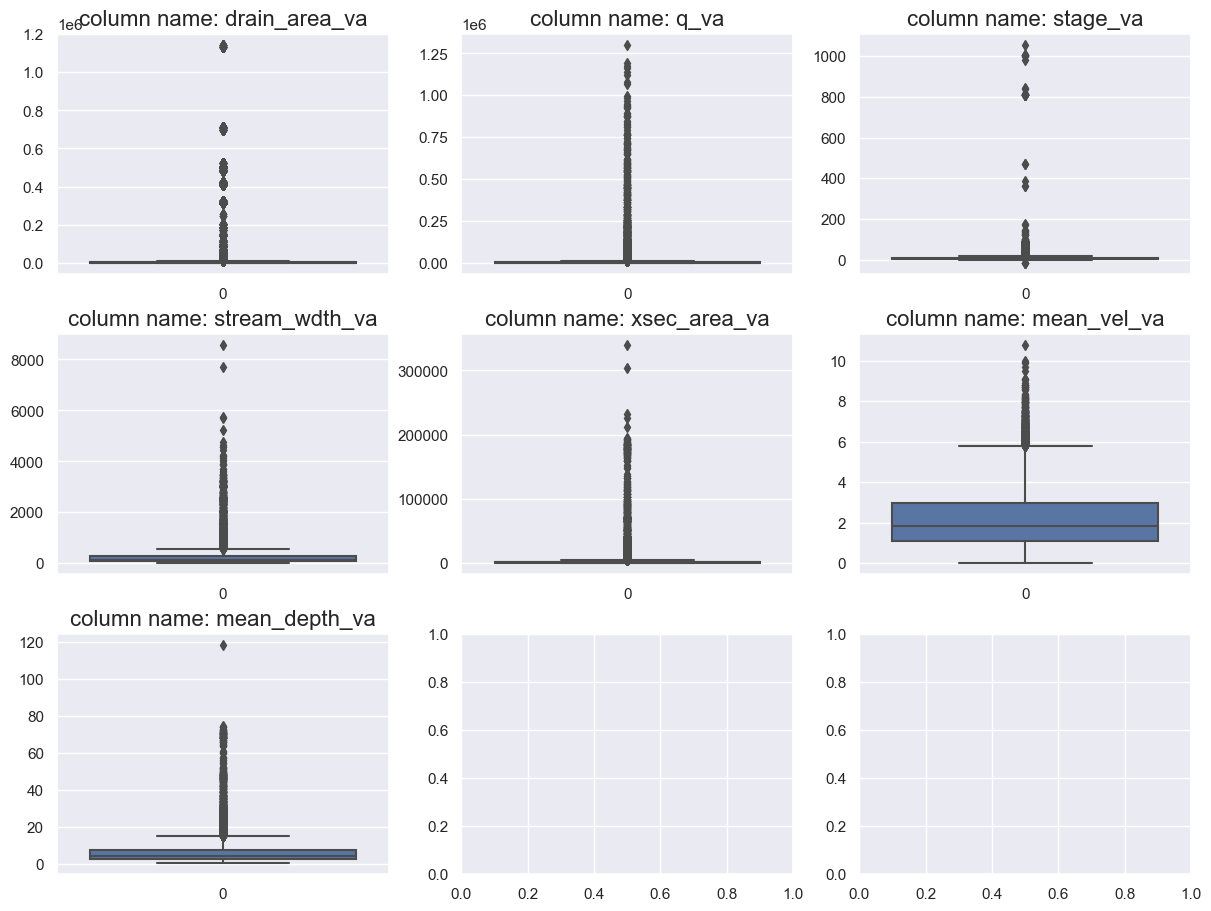

In [40]:
# Boxplot
fig, axes = plt.subplots(nrows=3, ncols=3 , figsize=(12, 9), constrained_layout=True)

for index, (column_name, column_data) in enumerate(df2.iteritems()):
    # print(column_name, column_data); continue
    i, j = divmod(index, 3)

    sns.boxplot(data=column_data, orient='v', ax=axes[i, j])
    axes[i, j].set_title(f'column name: {column_name}', fontsize=16)
    # axes[i, j].set_xlabel('')

# plt.savefig(f'{data_root}/results/boxplots.png')
plt.show()

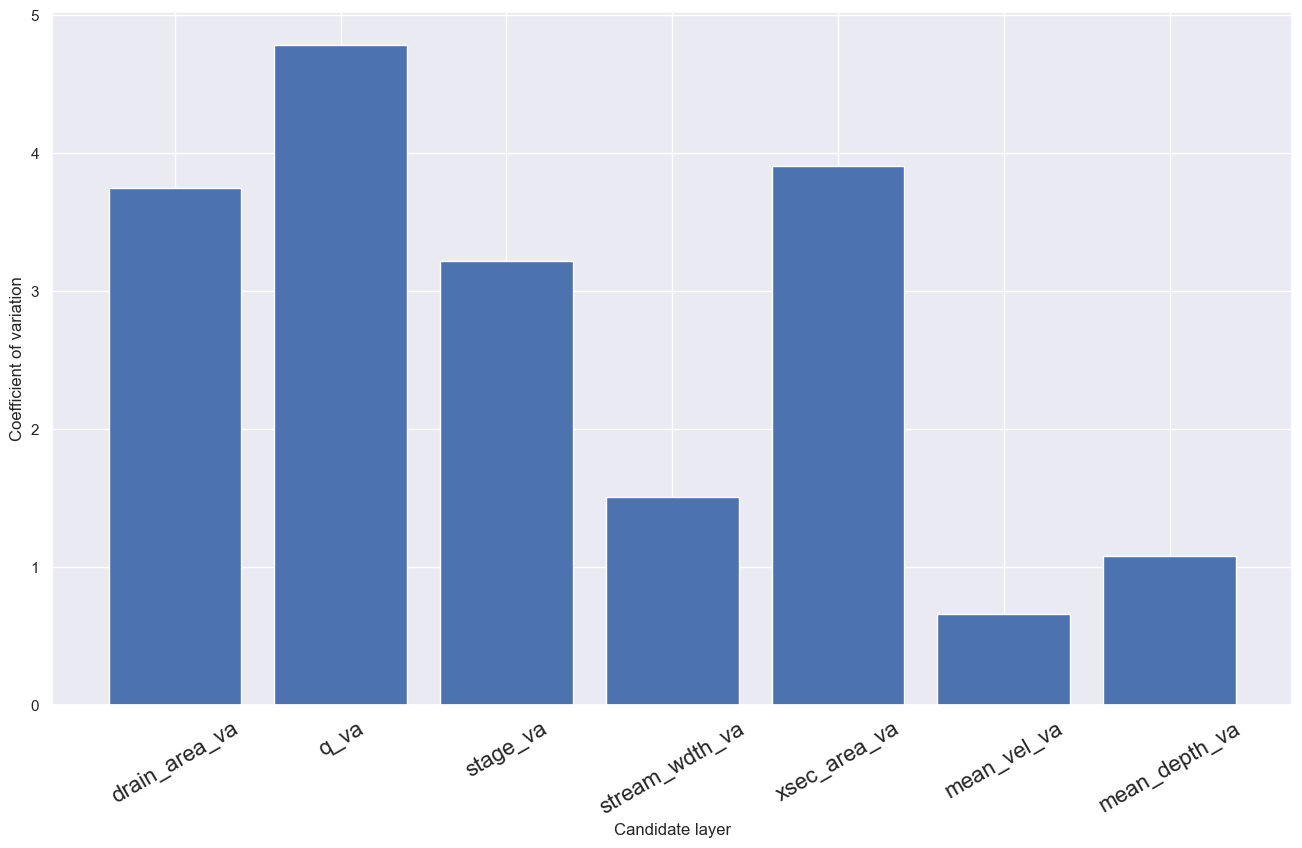

In [41]:
# coefficient of variation
cv_df = df2.std() / df2.mean()
cv_df = cv_df.reset_index().rename(columns={'index':'layer_name', 0:'cv'})
fig, ax = plt.subplots(figsize=(16,9))

ax.bar(cv_df['layer_name'], cv_df['cv'])
ax.tick_params(axis='x', labelrotation=30, labelsize=16)
ax.set_xlabel('Candidate layer')
ax.set_ylabel('Coefficient of variation')

# plt.savefig(f'{data_root}/results/cv.png')
plt.show()

In [66]:
candidate_columns = ['site_no', 'drain_area_va', 'q_va', 'stage_va', 'stream_wdth_va', 'xsec_area_va', 'mean_vel_va', 'mean_depth_va']

dataset = df1[candidate_columns]
dataset = dataset.dropna(axis=0, how='any', subset=['stage_va', 'xsec_area_va'])
dataset.reset_index(inplace=True, drop=True)
dataset.shape

(23306, 8)

In [87]:
from sklearn.model_selection import GroupShuffleSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor

splitter = GroupShuffleSplit(test_size=.20, n_splits=2, random_state = 7)
split = splitter.split(dataset, groups=dataset['site_no'])
train_idx, test_idx = next(split)

train = dataset.iloc[train_idx]
test = dataset.iloc[test_idx]

In [104]:
X_train = train.drop(columns=['site_no', 'mean_depth_va'])
X_test = test.drop(columns=['site_no', 'mean_depth_va'])

y_train = train[['mean_depth_va']]
y_test = test[['mean_depth_va']]

In [80]:
# Grid Search
param_grid = {'max_depth': range(5, 15, 2),
              'max_features': ['auto', 'sqrt', 'log2'],
              'min_samples_leaf': range(1, 8, 1),
              'min_samples_split': [2, 4, 8, 10],
              'n_estimators': range(10, 30, 5),
              'bootstrap': [True, False]
              }

rf = RandomForestRegressor(n_jobs=-1, random_state=42)
rf_grid = GridSearchCV(estimator=rf, param_grid=param_grid, cv=4, n_jobs=-1, verbose=True)
# scoring='neg_root_mean_squared_error'

In [81]:
rf_grid.fit(X_train, y_train)

Fitting 4 folds for each of 3360 candidates, totalling 13440 fits


C:\Users\SERFANI\.conda\envs\Geospatial\lib\site-packages\sklearn\model_selection\_search.py:910: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
C:\Users\SERFANI\.conda\envs\Geospatial\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


GridSearchCV(cv=4, estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': range(5, 15, 2),
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': range(1, 8),
                         'min_samples_split': [2, 4, 8, 10],
                         'n_estimators': range(10, 30, 5)},
             verbose=True)

In [84]:
rf_grid.best_score_
rf_grid.best_params_
rf_grid.best_estimator_

0.9261921971476557

In [85]:
predict = rf_grid.best_estimator_.predict(X_test)

In [105]:
y_test = y_test.to_numpy().ravel()

In [112]:
r2 = np.corrcoef(predict, y_test)[0, 1]**2
pbias = 100 * np.sum((predict - y_test)) / np.sum(y_test)
nse = r2_score(y_test, predict)
mse = mean_squared_error(y_test, predict, squared=False)
print(f'NSE: {nse:.4f}, R2: {r2:.4f}, PBias: {pbias:.4f}, MSE: {mse:.4f}')


NSE: 0.9326, R2: 0.9440, PBias: -2.4849, MSE: 1.7172


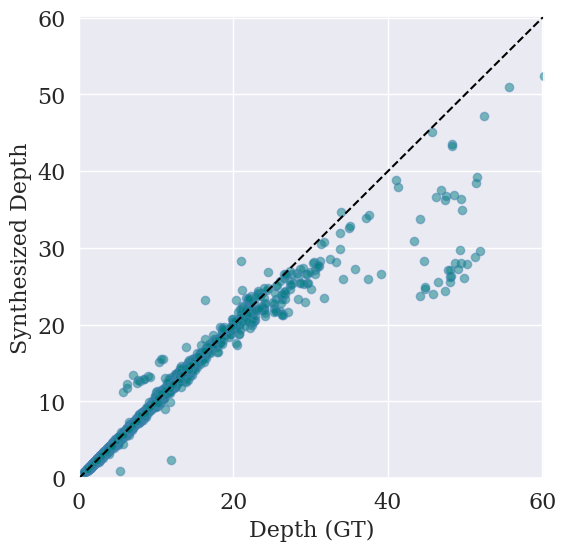

In [110]:
plt.rcParams.update({
    # 'font.sans-serif': 'Comic Sans MS',
    'font.family': 'serif'
})

fig, ax = plt.subplots(ncols=1,figsize=(6, 6))

max_value = np.array((y_test, predict)).max()

ax.scatter(y_test, predict, color='teal', edgecolor='steelblue', alpha=0.5, label="Left Bankline")
# ax.scatter(df["Right_BL"], df["Aava"], color='lightcoral', edgecolor='darkred', alpha=0.7, label="Right Bankline")
ax.plot([0, max_value], [0, max_value], '--', color = 'black', linewidth=1.5)

# axes[0].set_yscale('log')
# axes[0].set_xscale('log')

# sfont = {'fontname': 'Times New Roman'}
ax.set_xlabel('Depth (GT)', fontsize=16) # **sfont
ax.tick_params(axis='x', labelsize=16)
ax.set_xlim(0, max_value)

ax.set_ylabel('Synthesized Depth', fontsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.set_ylim(0, max_value)
ax.grid(True)

# Change the font for the tick marks (only)

# for tick in ax.get_xticklabels():
#     tick.set_fontname('Times New Roman')
# for tick in ax.get_yticklabels():
#     tick.set_fontname('Times New Roman')

# plt.legend(fontsize=18, loc=2)
plt.savefig("./rf_scplot.png")
plt.show()